In [4]:
import numpy as np
import matplotlib.pyplot as plt
from spike_generators import GutniskyUnivariateSpikeGenerator, KaulakysUnivariateSpikeGenerator

from scipy.signal import lfilter, welch
from scipy.fft import fft, ifft

In [5]:
# Pink noise generation

## TODO: Author / Source ??

def minmax(x):
    """min max normalizes the given array"""
    return (x - np.min(x))/(np.max(x)-np.min(x))

def generate_pink_noise(num_traces = 100, num_samples = 4999):
    """
    Modulates a generated gausian white noise trace to create pink noise.
    
    Parameters
    ----------
    num_traces : int, optional
        number of noise traces to create (first dimension), by default 100
    num_samples : int, optional
        length of the trace (second dimension), by default 4999
    Returns
    -------
    np.array
        noise trace
    """    
    B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]  #The coefficient A, B determines a filter that converts white noise to 1/f spectrum. 
    A = [1, -2.494956002,   2.017265875,  -0.522189400]         #You can use this function to check the frequency response of the filter, which should give you a 1/f amplitude response.

    invfn = np.zeros((num_traces,num_samples))
    for i in np.arange(0,num_traces):
        wn = np.random.normal(loc=1, scale=0.5, size=num_samples+2000)
        invfn[i,:] = wn[2000:]
        invfn[i,:] = minmax(lfilter(B, A, wn)[2000:])+0.5                # Filtering white noise to create a close approximation of '1/f' Noise
                                                                            # The filtered signal is pink noise with 0 mean. 
                                                                            # The minmax function normalizes the signal to have values between [0,1].
                                                                            # Adding 0.5 to it makes it positive and have mean 1, since firing rate cannot be negative
    return invfn

freq: (129,), psd: (129,)


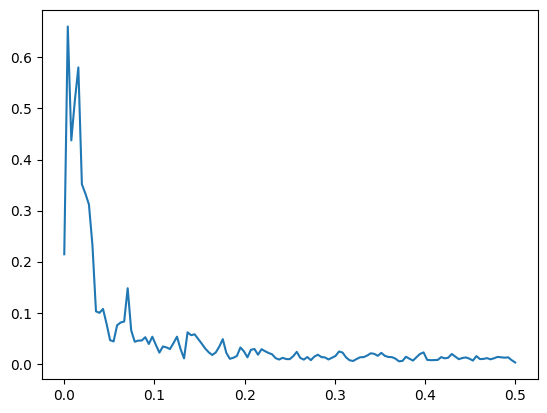

In [6]:
pink_noise = generate_pink_noise(1, 1000)
freq, psd = welch(pink_noise)
psd = psd.flatten()

print(f"freq: {freq.shape}, psd: {psd.shape}")

plt.plot(freq, psd)

/opt/anaconda3/envs/brainlab/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


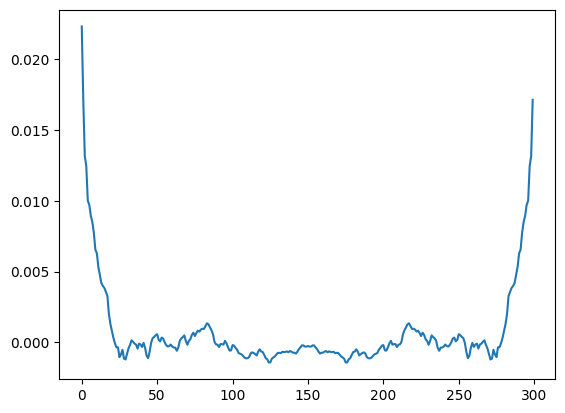

In [7]:
autocov = ifft(psd, 300)
plt.plot(autocov)

In [8]:
mean_spiking_rate = 0.003
spike_train_length = len(autocov)
spike_train_autocov = autocov

#### Gutnisky

Accepts a neuron's mean spiking rate and a vector of autocovariances between spikes $[Cov(y_t, y_t), Cov(y_t, y_{t-1}), \ldots, Cov(y_t, y_{t-k})]$. Outputs the generated spike train and interspike times.

**Note:** it is randomized algorithm, so it needs to be re-run until the desired PSD is produced.

In [18]:
sp_gen_gutisky = GutniskyUnivariateSpikeGenerator()
train, times, y = sp_gen_gutisky.get_spike_train(mean_spiking_rate, spike_train_autocov)

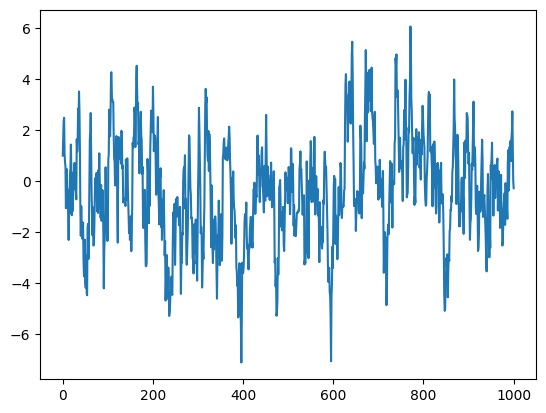

In [19]:
plt.plot(y)

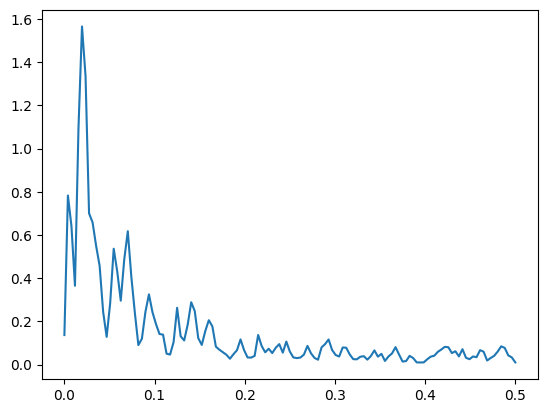

In [20]:
freq, psd = welch(train)
plt.plot(freq, psd, label = "PSD")

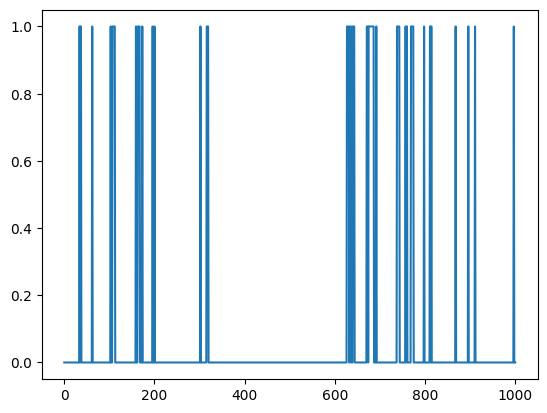

In [21]:
plt.plot(train)

#### Kaulakys

Accepts a neuron's mean spiking rate and length of the spike train. Outputs **interspike times** which are correlated as $1/f$.

**Note:** it is randomized algorithm, so it needs to be re-run until the desired PSD is produced.

In [78]:
mean_spiking_rate = 1
sp_gen_kaulakys = KaulakysUnivariateSpikeGenerator()
train, interevent_times = sp_gen_kaulakys.get_spike_train(1, 1000, 0.01)

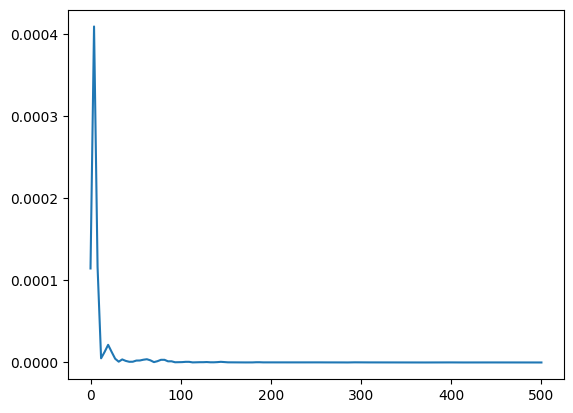

In [80]:
freq, psd = welch(interevent_times, fs = 1000)
plt.plot(freq, psd)